In [1]:
import re
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

[nltk_data] Downloading package punkt to /Users/joshsolis/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshsolis/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

In [89]:
##### Your Code Here #####
from bs4 import BeautifulSoup
import requests

import pandas
import time

page_to_scrape = 'https://www.indeed.com/jobs?q=data+scientist&l=New+York,+NY&start=100'

page = requests.get(page_to_scrape)

soup = BeautifulSoup(page.text, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html dir="ltr" lang="en">
 <head>
  <meta content="text/html;charset=utf-8" http-equiv="content-type"/>
  <script src="/s/e8e398d/en_US.js" type="text/javascript">
  </script>
  <link href="/s/97464e7/jobsearch_all.css" rel="stylesheet" type="text/css"/>
  <link href="http://rss.indeed.com/rss?q=data+scientist&amp;l=New+York%2C+NY" rel="alternate" title="Data Scientist Jobs, Employment in New York, NY" type="application/rss+xml"/>
  <link href="/m/jobs?q=data+scientist&amp;l=New+York%2C+NY" media="only screen and (max-width: 640px)" rel="alternate"/>
  <link href="/m/jobs?q=data+scientist&amp;l=New+York%2C+NY" media="handheld" rel="alternate"/>
  <script type="text/javascript">
   if (typeof window['closureReadyCallbacks'] == 'undefined') {
        window['closureReadyCallbacks'] = [];
    }

    function call_when_jsall_loaded(cb) {
        if (window['closureReady']) {
            cb();
        } else {
            window['closureReadyCallbacks'].push(cb);
        }


In [29]:
def extract_job_title_from_result(soup): 
    jobs = []
    for div in soup.find_all(name="div", attrs={"class":"row"}):
        for a in div.find_all(name="a", attrs={"data-tn-element":"jobTitle"}):
            jobs.append(a["title"])
    return(jobs)

extract_job_title_from_result(soup)

['Staff Data Scientist - Technology - New York, NY',
 'Data Scientist',
 'AI Scientist',
 'Sr. Data Scientist',
 'Data Scientist (Data Startup)',
 'Entry Level Data Scientist',
 'Data Scientist',
 '2019 University Graduate - Data Scientist - UberEverything (New York)',
 'Associate Data Scientist – Premium Analytics',
 'Data Scientist',
 'Data Scientist',
 'Junior Data Scientist',
 'Data Scientist',
 'Data Scientist - Uber Everything (NYC)',
 'Data Scientist',
 'Data Scientist I',
 'Data Scientist/Data Science Instructor']

In [30]:
def extract_company_from_result(soup): 
    companies = []
    for div in soup.find_all(name="div", attrs={"class":"row"}):
        company = div.find_all(name="span", attrs={"class":"company"})
        if len(company) > 0:
            for b in company:
                companies.append(b.text.strip())
        else:
            sec_try = div.find_all(name="span", attrs={"class":"result-link-source"})
            for span in sec_try:
                companies.append(span.text.strip())
    return(companies)
 
extract_company_from_result(soup)

['Finra',
 'Disney Streaming Services',
 'Accrete.AI',
 'Vibrant Emotional Health',
 'Averity',
 'AECOM',
 'AETNA',
 'Uber',
 'Spotify',
 'Everytown for Gun Safety',
 'Butterfly Network',
 '1-800-Flowers.com',
 'Audible, Inc.',
 'Uber',
 'Atlantic Media',
 'AIG',
 'NYC Data Science Academy']

In [96]:
def extract_location_from_result(soup): 
    locations = []
    spans = soup.findAll(attrs={'class': 'location'})
    for span in spans:
        locations.append(span.text)
    return(locations)
len(extract_location_from_result(soup))

15

In [95]:
def extract_summary_from_result(soup): 
    summaries = []
    spans = soup.findAll(attrs={'class': 'summary'})
    for span in spans:
        summaries.append(span.text.strip())
    return(summaries)
len(extract_summary_from_result(soup))


15

In [93]:
# Makes urls to be scraped via looking at link format
def make_urls(job_title, location, max_jobs):
    num_pages = max_jobs // 10
    job_title = job_title.replace(' ', '+')
    location = location.replace(' ', '+')
    
    URLs = []
    
    root = 'https://www.indeed.com/jobs?q='
    pageNum=0
    for page in range(num_pages):
        if pageNum == 0:
            seedURL = root+job_title+'&l='+location + '&start=0'
        else:
            jobNum = pageNum*10
            jobNum = str(jobNum)
            seedURL = root + job_title + '&l=' + location + '&start='+jobNum
        pageNum += 1
        URLs.append(seedURL)
    return URLs
        
urls = make_urls('data scientist', 'New York, NY', 80)
print(urls)

['https://www.indeed.com/jobs?q=data+scientist&l=New+York,+NY&start=0', 'https://www.indeed.com/jobs?q=data+scientist&l=New+York,+NY&start=10', 'https://www.indeed.com/jobs?q=data+scientist&l=New+York,+NY&start=20', 'https://www.indeed.com/jobs?q=data+scientist&l=New+York,+NY&start=30', 'https://www.indeed.com/jobs?q=data+scientist&l=New+York,+NY&start=40', 'https://www.indeed.com/jobs?q=data+scientist&l=New+York,+NY&start=50', 'https://www.indeed.com/jobs?q=data+scientist&l=New+York,+NY&start=60', 'https://www.indeed.com/jobs?q=data+scientist&l=New+York,+NY&start=70']


In [98]:
# I will write a function to perform the scraping 
# for each webpage made by make_urls, and return a dataframe

def scrape_indeed(urls):
    job_title = []
    company = []
    location = []
    summary = []
    for url in urls:
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'html.parser')
        job_title+=extract_job_title_from_result(soup)
        company+=extract_company_from_result(soup)
        location+=extract_location_from_result(soup)
        summary+=extract_summary_from_result(soup)
    #return len(job_title), len(company), len(location), len(summary)
    
    return pd.DataFrame({'job_title':job_title, 'company':company,
                        'location':location, 'summary':summary})

df = scrape_indeed(urls)
df

job_title  \
0     Staff Data Scientist - Technology - New York, NY   
1                                         AI Scientist   
2                        Data Scientist (Data Startup)   
3                                       Data Scientist   
4                                   Sr. Data Scientist   
5                           Entry Level Data Scientist   
6    2019 University Graduate - Data Scientist - Ub...   
7                                       Data Scientist   
8         Associate Data Scientist – Premium Analytics   
9                                       Data Scientist   
10                               Junior Data Scientist   
11                                      Data Scientist   
12                                      Data Scientist   
13              Data Scientist - Uber Everything (NYC)   
14                                      Data Scientist   
15                                    Data Scientist I   
16              Data Scientist/Data Science Instructor   
17              Data Scientist/Data Science Instructor   
18                                        AI Scientist   
19                       Data Scientist (Data Startup)   
20                                      Data Scientist   
21                                  Sr. Data Scientist   
22                                      Data Scientist   
23                 Data Scientist, Connected Solutions   
24                                      Data Scientist   
25                               Junior Data Scientist   
26                             Data Scientist, Product   
27                            Associate Data Scientist   
28                               Data Scientist, Sales   
29                                    Data Scientist I   
..                                                 ...   
104                        Quantitative Data Scientist   
105                                     Data Scientist   
106                                     Data Scientist   
107                                     Data Scientist   
108                                     Data Scientist   
109                            Data Scientist, Clients   
110                  Data Scientist – Machine Learning   
111                                     Data Scientist   
112                                 Sr. Data Scientist   
113                      Data Scientist (Data Startup)   
114                                   Data Scientist I   
115   Staff Data Scientist - Technology - New York, NY   
116                                     Data Scientist   
117             Data Scientist/Data Science Instructor   
118                                       AI Scientist   
119                                     Data Scientist   
120                                   Data Scientist I   
121                                     Data Scientist   
122                                     Data Scientist   
123                                     Data Scientist   
124                                     Data Scientist   
125                                     Data Scientist   
126                                Risk Data Scientist   
127                            Data Scientist, Redtech   
128                             Data Scientist, CHOICE   
129                                     Data Scientist   
130                                   Data Scientist I   
131   Staff Data Scientist - Technology - New York, NY   
132             Data Scientist/Data Science Instructor   
133                                       AI Scientist   

                                company  \
0                                 Finra   
1                            Accrete.AI   
2                               Averity   
3             Disney Streaming Services   
4              Vibrant Emotional Health   
5                                 AECOM   
6                                  Uber   
7                                 AETNA   
8                               Spotify   
9              Eve

## 2) Use NLTK to tokenize / clean the listings 

In [122]:
##### Your Code Here #####
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

cleaned_listings = []


import string
table = str.maketrans('','', string.punctuation)
stop_words = set(stopwords.words('english'))

for col in df.values.tolist():
    for entry in col:
        # Tokenize by word
        tokens = word_tokenize(entry)
        print("Tokens:", tokens)
        # Make all words lowercase
        lowercase_tokens = [w.lower() for w in tokens]
        print("Lowercase:", lowercase_tokens)
        # Strip punctuation from within words
        no_punctuation = [x.translate(table) for x in lowercase_tokens]
        print("No Punctuation:", no_punctuation)
        # Remove words that aren't alphabetic
        alphabetic = [word for word in no_punctuation if word.isalpha()]
        print("Alphabetic:", alphabetic)
        # Remove stopwords
        words = [w for w in alphabetic if not w in stop_words]
        print("Cleaned Words:", words)
        print("--------------------------------")
        # Append to list
        cleaned_listings.append(words)

Tokens: ['Staff', 'Data', 'Scientist', '-', 'Technology', '-', 'New', 'York', ',', 'NY']
Lowercase: ['staff', 'data', 'scientist', '-', 'technology', '-', 'new', 'york', ',', 'ny']
No Punctuation: ['staff', 'data', 'scientist', '', 'technology', '', 'new', 'york', '', 'ny']
Alphabetic: ['staff', 'data', 'scientist', 'technology', 'new', 'york', 'ny']
Cleaned Words: ['staff', 'data', 'scientist', 'technology', 'new', 'york', 'ny']
--------------------------------
Tokens: ['Finra']
Lowercase: ['finra']
No Punctuation: ['finra']
Alphabetic: ['finra']
Cleaned Words: ['finra']
--------------------------------
Tokens: ['New', 'York', ',', 'NY', '10005', '(', 'Financial', 'District', 'area', ')']
Lowercase: ['new', 'york', ',', 'ny', '10005', '(', 'financial', 'district', 'area', ')']
No Punctuation: ['new', 'york', '', 'ny', '10005', '', 'financial', 'district', 'area', '']
Alphabetic: ['new', 'york', 'ny', 'financial', 'district', 'area']
Cleaned Words: ['new', 'york', 'ny', 'financial', 'd

Cleaned Words: ['new', 'york', 'ny', 'chelsea', 'area']
--------------------------------
Tokens: ['You', '’', 've', 'worked', 'as', 'a', 'Data', 'Scientist', 'analyzing', 'complex', 'data', 'with', 'SQL', ',', 'Python', ',', 'and/or', 'R.', 'We', 'seek', 'an', 'extraordinary', 'Data', 'Scientist', 'to', 'join', 'our', 'Technology', 'Platform', '...']
Lowercase: ['you', '’', 've', 'worked', 'as', 'a', 'data', 'scientist', 'analyzing', 'complex', 'data', 'with', 'sql', ',', 'python', ',', 'and/or', 'r.', 'we', 'seek', 'an', 'extraordinary', 'data', 'scientist', 'to', 'join', 'our', 'technology', 'platform', '...']
No Punctuation: ['you', '’', 've', 'worked', 'as', 'a', 'data', 'scientist', 'analyzing', 'complex', 'data', 'with', 'sql', '', 'python', '', 'andor', 'r', 'we', 'seek', 'an', 'extraordinary', 'data', 'scientist', 'to', 'join', 'our', 'technology', 'platform', '']
Alphabetic: ['you', 've', 'worked', 'as', 'a', 'data', 'scientist', 'analyzing', 'complex', 'data', 'with', 'sql', 

Lowercase: ['data', 'scientist', 'i']
No Punctuation: ['data', 'scientist', 'i']
Alphabetic: ['data', 'scientist', 'i']
Cleaned Words: ['data', 'scientist']
--------------------------------
Tokens: ['AIG']
Lowercase: ['aig']
No Punctuation: ['aig']
Alphabetic: ['aig']
Cleaned Words: ['aig']
--------------------------------
Tokens: ['New', 'York', ',', 'NY']
Lowercase: ['new', 'york', ',', 'ny']
No Punctuation: ['new', 'york', '', 'ny']
Alphabetic: ['new', 'york', 'ny']
Cleaned Words: ['new', 'york', 'ny']
--------------------------------
Tokens: ['Data', 'Scientists', 'collaborate', 'with', 'AIG', '’', 's', 'Life', 'and', 'Retirement', 'businesses', 'across', 'multiple', 'functions', ',', 'including', 'product', ',', 'distribution', ',', 'marketing', ',', 'operations', ',', 'and', '...']
Lowercase: ['data', 'scientists', 'collaborate', 'with', 'aig', '’', 's', 'life', 'and', 'retirement', 'businesses', 'across', 'multiple', 'functions', ',', 'including', 'product', ',', 'distribution',

Alphabetic: ['new', 'york', 'ny']
Cleaned Words: ['new', 'york', 'ny']
--------------------------------
Tokens: ['We', 'are', 'looking', 'for', 'a', 'Data', 'Scientist', 'to', 'join', 'our', 'Business', 'Analytics', 'team', 'to', 'develop', ',', 'produce', ',', 'and', 'interpret', 'venue', 'and', 'broker', 'analytics', 'to', 'create', 'content', 'for', '...']
Lowercase: ['we', 'are', 'looking', 'for', 'a', 'data', 'scientist', 'to', 'join', 'our', 'business', 'analytics', 'team', 'to', 'develop', ',', 'produce', ',', 'and', 'interpret', 'venue', 'and', 'broker', 'analytics', 'to', 'create', 'content', 'for', '...']
No Punctuation: ['we', 'are', 'looking', 'for', 'a', 'data', 'scientist', 'to', 'join', 'our', 'business', 'analytics', 'team', 'to', 'develop', '', 'produce', '', 'and', 'interpret', 'venue', 'and', 'broker', 'analytics', 'to', 'create', 'content', 'for', '']
Alphabetic: ['we', 'are', 'looking', 'for', 'a', 'data', 'scientist', 'to', 'join', 'our', 'business', 'analytics', 

In [123]:
import itertools

single_cleaned_listing = list(itertools.chain.from_iterable(cleaned_listings))

single_cleaned_listing

['staff',
 'data',
 'scientist',
 'technology',
 'new',
 'york',
 'ny',
 'finra',
 'new',
 'york',
 'ny',
 'financial',
 'district',
 'area',
 'staff',
 'data',
 'scientist',
 'market',
 'regulation',
 'technology',
 'support',
 'establishment',
 'data',
 'science',
 'machine',
 'learning',
 'best',
 'practices',
 'finra',
 'moves',
 'ai',
 'scientist',
 'accreteai',
 'new',
 'york',
 'ny',
 'financial',
 'district',
 'area',
 'two',
 'three',
 'years',
 'experience',
 'artificial',
 'intelligence',
 'quantitative',
 'qualitative',
 'analytics',
 'deep',
 'learning',
 'machine',
 'learning',
 'natural',
 'language',
 'data',
 'scientist',
 'data',
 'startup',
 'averity',
 'new',
 'york',
 'ny',
 'use',
 'sophisticated',
 'machine',
 'learning',
 'ai',
 'data',
 'extraction',
 'provide',
 'predictive',
 'analytics',
 'market',
 'insight',
 'client',
 'base',
 'data',
 'scientist',
 'disney',
 'streaming',
 'services',
 'new',
 'york',
 'ny',
 'data',
 'scientist',
 'critical',
 'positio

In [124]:
from nltk.probability import FreqDist

fdist = FreqDist(single_cleaned_listing)
print(fdist)

fdist.most_common(20)

<FreqDist with 633 samples and 3146 outcomes>


[('data', 329),
 ('scientist', 165),
 ('ny', 140),
 ('new', 137),
 ('york', 133),
 ('area', 62),
 ('learning', 56),
 ('machine', 48),
 ('analytics', 41),
 ('science', 35),
 ('experience', 28),
 ('scientists', 27),
 ('financial', 26),
 ('district', 26),
 ('team', 24),
 ('technology', 21),
 ('insights', 20),
 ('health', 19),
 ('senior', 19),
 ('use', 18)]

# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [126]:
##### Your Code Here #####
for_vector_count = []

for listing in cleaned_listings:
    new_listing = " ".join(listing)
    for_vector_count.append(new_listing)

print(for_vector_count)


['staff data scientist technology new york ny', 'finra', 'new york ny financial district area', 'staff data scientist market regulation technology support establishment data science machine learning best practices finra moves', 'ai scientist', 'accreteai', 'new york ny financial district area', 'two three years experience artificial intelligence quantitative qualitative analytics deep learning machine learning natural language', 'data scientist data startup', 'averity', 'new york ny', 'use sophisticated machine learning ai data extraction provide predictive analytics market insight client base', 'data scientist', 'disney streaming services', 'new york ny', 'data scientist critical position within dss data organization specializes applying machine learning methods meet optimization', 'sr data scientist', 'vibrant emotional health', 'new york ny financial district area', 'senior data scientist experience communicating domain stakeholders health mental health senior data scientist team le

In [127]:
# Instantiate vectorizer object
vectorizer = CountVectorizer()
# Create a vocabulary and get word counts per document
bag_of_words = vectorizer.fit_transform(for_vector_count)
# Print word counts
print(bag_of_words.toarray())

# Get feature names to use as dataframe column headers
feature_names = vectorizer.get_feature_names()

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]]


In [130]:
df = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
df.head()

ability  able  academy  accreteai  accurate  across  actionable  actively  \
0        0     0        0          0         0       0           0         0   
1        0     0        0          0         0       0           0         0   
2        0     0        0          0         0       0           0         0   
3        0     0        0          0         0       0           0         0   
4        0     0        0          0         0       0           0         0   

   add  advanced  ...  work  worked  workforce  working  world  wrangling  \
0    0         0  ...     0       0          0        0      0          0   
1    0         0  ...     0       0          0        0      0          0   
2    0         0  ...     0       0          0        0      0          0   
3    0         0  ...     0       0          0        0      0          0   
4    0         0  ...     0       0          0        0      0          0   

   writing  years  york  zocdoc  
0        0      0     1       0  
1        0      0     0       0  
2        0      0     1       0  
3        0      0     0       0  
4        0      0     0       0  

[5 rows x 631 columns]

# 4) Visualize the most common word counts

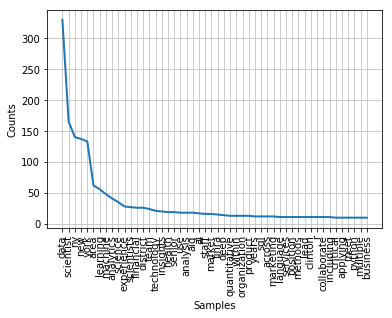

In [121]:
##### Your Code Here #####
import matplotlib.pyplot as plt
fdist.plot(50,cumulative=False)
plt.show()

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [131]:
##### Your Code Here #####
# List of document strings as text
text = for_vector_count
# Instantiate vectorizer object
tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=20)
# Create a vocabulary and get word counts per document
feature_matrix = tfidf.fit_transform(text)
# Print word counts
# print(feature_matrix.toarray())

# Get feature names to use as dataframe column headers
feature_names = tfidf.get_feature_names()

# View Feature Matrix as DataFrame
df = pd.DataFrame(feature_matrix.toarray(), columns=feature_names)
print(df.shape)
df.head()

(536, 20)


analytics      area      data  district  experience  financial  health  \
0        0.0  0.000000  0.276151  0.000000         0.0   0.000000     0.0   
1        0.0  0.000000  0.000000  0.000000         0.0   0.000000     0.0   
2        0.0  0.411086  0.000000  0.521913         0.0   0.521913     0.0   
3        0.0  0.000000  0.423065  0.000000         0.0   0.000000     0.0   
4        0.0  0.000000  0.000000  0.000000         0.0   0.000000     0.0   

   insights  learning   machine       new        ny   science  scientist  \
0       0.0  0.000000  0.000000  0.361630  0.358333  0.000000   0.341854   
1       0.0  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
2       0.0  0.000000  0.000000  0.308524  0.305711  0.000000   0.000000   
3       0.0  0.398611  0.398611  0.000000  0.000000  0.438126   0.261861   
4       0.0  0.000000  0.000000  0.000000  0.000000  0.000000   1.000000   

   scientists  senior  team  technology  use      york  
0         0.0     0.0   0.0    0.643148  0.0  0.366140  
1         0.0     0.0   0.0    0.000000  0.0  0.000000  
2         0.0     0.0   0.0    0.000000  0.0  0.312371  
3         0.0     0.0   0.0    0.492654  0.0  0.000000  
4         0.0     0.0   0.0    0.000000  0.0  0.000000

## Stretch Goals

 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.